In [1]:
import dask.dataframe as dd
import dask.array as da
import os
import csv
import numba
import numpy as np
from tqdm import tqdm_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math as m
import pandas as pd
import dask
import xarray as xr
import scipy.io as sio
from scipy import ndimage
from scipy.interpolate import interp1d

In [2]:
solar_path = 'Aug14SolarRef.dat'
HySICS_wl_path = 'HySICS files/WLHysics.sav'

HySICS_LW_data_path = 'Desert_vegetation_clouds/'
LW_datacube_path = 'data_cube_water.npy'
LW_rgb_path = 'rgb_water.npy'
LRT_LW_path = 'WC files/'
verbose_LW_path = 'WC files/verbose/'

HySICS_IC_data_path = 'Thick_clouds1/'
IC_datacube_path = 'data_cube_ice.npy'
IC_rgb_path = 'rgb_ice.npy'
LRT_IC_path = 'IC files/ghm/'
verbose_IC_path = 'IC files/ghm/verbose_ghm/'

In [3]:
def read_HySICS_wl(file):
    hysics_wl = sio.readsav(file)
    hysics_wl = hysics_wl['wlsample']
    hysics_wl = [x+3.5 for x in hysics_wl]
    return hysics_wl;

@dask.delayed
def read_df(file):
    try:
        array = np.genfromtxt(file,delimiter=',')
        return array
    except:
        pass

def generate_datacube(path,wl_list):
    files = [os.path.join(path,f) for f in os.listdir(path) if f.startswith('img')]
    files.sort()

    dfs = [read_df(file) for file in files]

    sample = dfs[0].compute()
    das = [da.from_delayed(item, shape=sample.shape, dtype=sample.dtype) for item in dfs]
    array = da.stack(das)

    datacube = xr.DataArray(array, dims=['x', 'y', 'wavelength'], name='datacube', coords={'wavelength':wl_list})
    return datacube;

#wl_list = read_HySICS_wl('HySICS files/WLHysics.sav')
#datacube_dvc = generate_datacube('Desert_vegetation_clouds/',wl_list)
#datacube_dvc.to_netcdf('datacube_dvc_april10.nc',format='NETCDF4')

In [4]:
#wl_list = read_HySICS_wl('HySICS files/WLHysics.sav')
#datacube_dvc = generate_datacube('Desert_vegetation_clouds/',wl_list)

In [5]:
#datacube_dvc.to_netcdf('datacube_dvc_april10.nc',format='NETCDF4')

In [6]:
def two_percent_linear_stretch(x,idx):
    c = x.isel(wavelength=idx)/np.amax(x.isel(wavelength=idx))
    p2, p98 = np.percentile(c, (2, 98))
    c_scaled = exposure.rescale_intensity(c, in_range=(p2, p98))
    return c_scaled;

def find_rgb_idx(wl_list):
    r_idx = np.argmin([np.abs(670 - x) for x in wl_list])
    g_idx = np.argmin([np.abs(555 - x) for x in wl_list])
    b_idx = np.argmin([np.abs(443 - x) for x in wl_list])
    rgb_idx_list = [r_idx,g_idx,b_idx]
    return (rgb_idx_list); 

def apply_stretch(datacube):
    rgb_idx_list = find_rgb_idx(datacube.coords['wavelength'])
    
    red = two_percent_linear_stretch(datacube,rgb_idx_list[0])
    green = two_percent_linear_stretch(datacube,rgb_idx_list[1])
    blue = two_percent_linear_stretch(datacube,rgb_idx_list[2])

    rgb = np.dstack((red,green,blue))
    rgb = xr.DataArray(rgb,dims=('x','y','rgb'))
    return rgb;   

#rgb = apply_stretch(datacube_dvc)
#rgb.to_netcdf('rgb_dvc_april10.nc',format='NETCDF4')

In [7]:
datacube_dvc = xr.open_dataarray('datacube_dvc_april10.nc',chunks=100)
rgb = xr.open_dataarray('rgb_dvc_april10.nc',chunks=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Desert Vegetation Clouds')

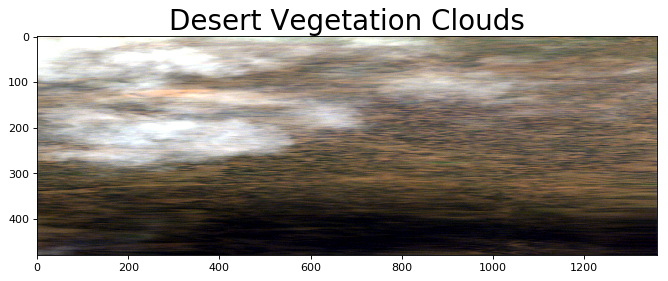

In [8]:
rotated_img = ndimage.rotate(rgb, -90)
# flipped_img = np.flipud(rotated_img)

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(rotated_img)
plt.title('Desert Vegetation Clouds',fontsize=25)

In [9]:
def read_solar(file):
    d = np.loadtxt(file, delimiter="\t")
    solar_wl=d[:,0]
    solar_flux=d[:,1]
    solar_flux = np.array([i/1000 for i in solar_flux]) 
    solar = xr.DataArray(solar_flux,dims=['wavelength'], name='solar flux', coords={'wavelength':solar_wl})
    return solar; 

solar = read_solar(solar_path) 
solar

<xarray.DataArray 'solar flux' (wavelength: 2500)>
array([1.58e-05, 2.52e-05, 8.50e-05, ..., 4.37e-02, 4.36e-02, 4.35e-02])
Coordinates:
  * wavelength  (wavelength) float64 115.5 116.5 117.5 ... 2.614e+03 2.614e+03

Text(0.5, 1.0, 'NRLSSI2 Solar Data for August 18th, 2014')

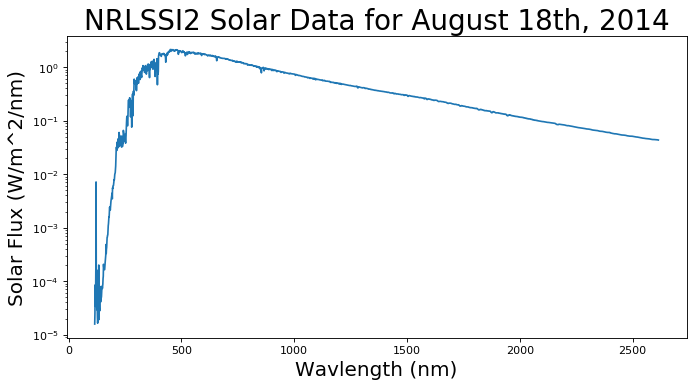

In [10]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(solar.wavelength,solar.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Solar Flux (W/m^2/nm)',fontsize=18)
tt = 'NRLSSI2 Solar Data for August 18th, 2014'
plt.title(tt,fontsize=25)

In [11]:
def read_verbose(verbose_file,phase):
    data = [x for x in open(verbose_file,'r')]
    a = data.index('Using new intensity correction, with phase functions\n')
    n=4 if phase=='Liquid Water' else 5
    tau = data[a:][67].split('|')[n].split()[0]
    return(tau);

def read_LRT(file,phase):
    fs = file.split('_')
    reff = fs[3][1:] if phase =='Liquid Water' else fs[2][1:]
    
    fv = file.split('/')
    ff = fv[1][0:-4] if phase =='Liquid Water' else fv[1][0:-4]
    end = '_550nm_verbose.txt'
    verbose_file = fv[0]+'/verbose/'+ff+end
    tau = read_verbose(verbose_file,phase)
    
    data = [x for x in csv.reader(open(file,'r'),delimiter='\t')]  
    data = data[3:] if phase == 'Liquid Water' else data[5:] 
    
    loops = int(len(data)/3)
    dirL = [np.float(data[3*n+2][0][9:24]) for n in range(loops)]#Direct Radiance (W/m^2/nm/sr)
    wl = [np.float(data[3*n][0][1:9]) for n in range(loops)]#Wavelength (nm)       

    dirLW = [i*10**-3 for i in dirL] #convert to W/m^2/nm/sr
    
    lrt_radiances = xr.DataArray(dirLW, dims=['wavelength'], name='LRT', coords={'wavelength':wl})
    lrt_radiances.attrs['COT'] = tau
    lrt_radiances.attrs['r_eff'] = reff
    return lrt_radiances;

def filter_wl(da):
    wl_min = 450 ; wl_max = 2300
    daf = da.where(da.wavelength>wl_min, drop=True)
    daf = daf.where(da.wavelength<wl_max, drop=True)
    return daf;

def get_sample_lrt_radf(path,phase):
    files = [os.path.join(path,f) for f in os.listdir(path)]
    file = files[0]
    lrt_rad = read_LRT(file,phase)
    lrt_radf_samp = filter_wl(lrt_rad)
    return (files, lrt_radf_samp);

path = 'WC files/'
phase = 'Liquid Water'
lrt_files, lrt_radf_samp = get_sample_lrt_radf(path,phase)
lrt_radf_samp

<xarray.DataArray (wavelength: 617)>
array([0.070049, 0.06797 , 0.068903, ..., 0.001743, 0.001604, 0.001597])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.296e+03 2.3e+03
Attributes:
    COT:      1.529480
    r_eff:    37.5

Text(0.5, 1.0, 'Sample LibRadtran Water Cloud Spectra')

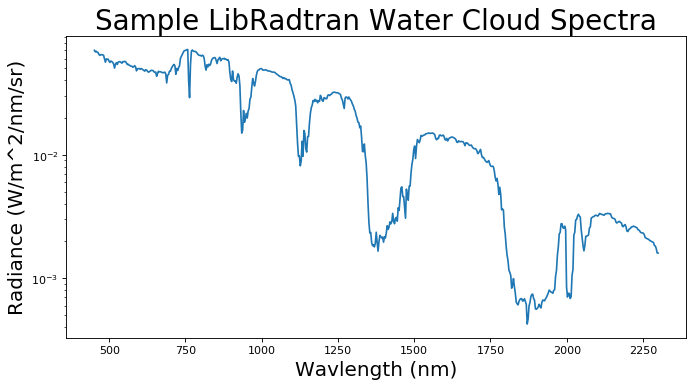

In [12]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(lrt_radf_samp.wavelength,lrt_radf_samp.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'Sample LibRadtran Water Cloud Spectra'
plt.title(tt,fontsize=25)

In [13]:
def interpolate_solar(lrt_radf,solar):
    f = interp1d(solar.wavelength,solar.values,fill_value='NaN')
    solar_new = f(lrt_radf.wavelength)
    
    solar_interp = xr.DataArray(solar_new,dims=['wavelength'], name='interpolated solar flux', coords={'wavelength':lrt_radf.wavelength})
    return solar_interp;

solar_interp = interpolate_solar(lrt_radf_samp,solar)
solar_interp

<xarray.DataArray 'interpolated solar flux' (wavelength: 617)>
array([2.14  , 2.07  , 2.13  , ..., 0.0705, 0.0701, 0.0697])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.296e+03 2.3e+03

Text(0.5, 1.0, 'Interpolated NRLSSI2 Solar Data')

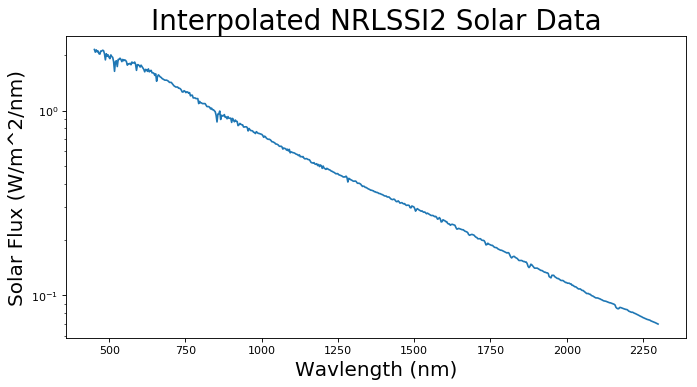

In [14]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(solar_interp.wavelength,solar_interp.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Solar Flux (W/m^2/nm)',fontsize=18)
tt = 'Interpolated NRLSSI2 Solar Data'
plt.title(tt,fontsize=25)

In [15]:
def calc_LRT_reflectance(lrt_radf,solar_interp,phase):
    sza = 38.5 if phase == 'Liquid Water' else 56
    mu = m.cos(m.radians(sza))
    refl_lrt = [np.pi/mu*lrt_radf.values[w]/solar_interp.values[w] for w in np.arange(0,len(lrt_radf.wavelength))]
                                                                        
    refl_lrt = xr.DataArray(refl_lrt,dims=['wavelength'], name='lrt reflectances', coords={'wavelength':lrt_radf.wavelength})
    refl_lrt.attrs['COT'] = lrt_radf.attrs['COT']
    refl_lrt.attrs['r_eff'] = lrt_radf.attrs['r_eff']   
    refl_lrt.attrs['rad'] = lrt_radf.values
    return refl_lrt;

def gen_refl_lrt_list(files,solar_interp,phase):
    refl_lrt_list = []
    lrt_rads = [read_LRT(f,phase) for f in files if f.endswith('.dat')]
    lrt_radfs = [filter_wl(lrt_rad)for lrt_rad in lrt_rads]
    refl_lrts = [calc_LRT_reflectance(r,solar_interp,phase) for r in lrt_radfs]
    return (refl_lrts);

refl_lrt_list = gen_refl_lrt_list(lrt_files,solar_interp,phase)
refl_lrt_list[0]

<xarray.DataArray 'lrt reflectances' (wavelength: 617)>
array([0.1314  , 0.131812, 0.129856, ..., 0.099224, 0.091879, 0.091982])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.296e+03 2.3e+03
Attributes:
    COT:      1.529480
    r_eff:    37.5
    rad:      [0.0700492  0.0679702  0.06890282 0.06752033 0.06729526 0.06475...

In [16]:
def find_retrieval_wavelengths(num_wl): 
    if num_wl%5 !=0: print('Number of wavelengths in algorithm must be a factor of 5.')   
    
    if (num_wl ==5):
        retrieval_wl_list=[[750], [1000], [1200], [1660], [2200]]
    else:
        wl_lims = [[600,750], [1000,1080], [1240,1320], [1600,1750], [2100,2200]]
        num = int(num_wl/5)
        retrieval_wl_list = [np.linspace(wl_lims[w][0],wl_lims[w][1],num) for w in np.arange(0,5)]
    
    return retrieval_wl_list;

wl_num=15
retrieval_wl_list = find_retrieval_wavelengths(wl_num)
retrieval_wl_list

[array([600., 675., 750.]),
 array([1000., 1040., 1080.]),
 array([1240., 1280., 1320.]),
 array([1600., 1675., 1750.]),
 array([2100., 2150., 2200.])]

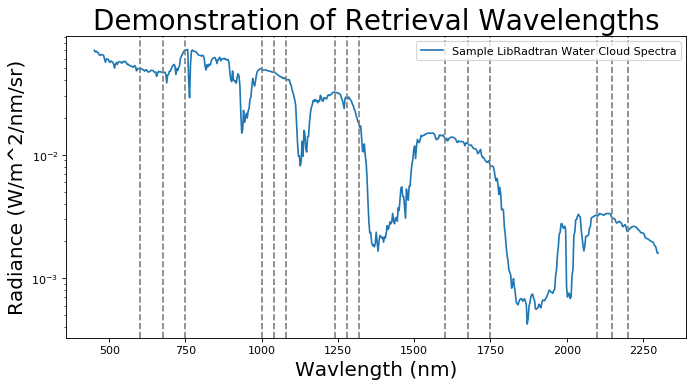

In [17]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(lrt_radf_samp.wavelength,lrt_radf_samp.values,label='Sample LibRadtran Water Cloud Spectra')
[plt.axvline(w,linestyle='--',c='grey') for w in np.ravel(retrieval_wl_list)]
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Radiance (W/m^2/nm/sr)',fontsize=18)
tt = 'Demonstration of Retrieval Wavelengths'
plt.title(tt,fontsize=25)
plt.legend()

In [18]:
def find_retrieval_idx_list(retrieval_wl_list,solar_interp):   
    idx_list = []
    for i in np.arange(0,5):
        cols = []
        for j in np.arange(0,len(retrieval_wl_list[0])):
            a = [np.min(np.abs(retrieval_wl_list[i][j] - x)) for x in solar_interp.wavelength] 
            val, idx = min((val, idx) for (idx, val) in enumerate(a))
            cols.append(int(idx))
        idx_list.append(cols)
    return idx_list;

retrieval_idx_list = find_retrieval_idx_list(retrieval_wl_list,solar_interp)
retrieval_idx_list

[[49, 74, 99],
 [183, 196, 209],
 [263, 276, 289],
 [383, 408, 433],
 [549, 566, 583]]

In [19]:
def calc_HySICS_reflectance(datacube,x,y,solar_interp,phase):    
    f = interp1d(datacube[x][y].wavelength,datacube[x][y].values,fill_value='NaN')
    hy_new = f(solar_interp.wavelength)
    
    sza = 38.5 if phase == 'Liquid Water' else 56
    mu = m.cos(m.radians(sza))
    refl_HySICS= [np.pi/mu*hy_new[w]/solar_interp.values[w] for w in np.arange(0,len(solar_interp.wavelength))]
    
    refl_hysics = xr.DataArray(refl_HySICS,dims=['wavelength'], name='HySICS reflectance', coords={'wavelength':solar_interp.wavelength})
    refl_hysics.attrs['x'] = x
    refl_hysics.attrs['y'] = y
    return refl_hysics;
refl_hysics_pixel = calc_HySICS_reflectance(datacube_dvc,0,0,solar_interp,phase)
refl_hysics_pixel

<xarray.DataArray 'HySICS reflectance' (wavelength: 617)>
array([0.053055, 0.077498, 0.068279, ..., 0.22207 , 0.213657, 0.222178])
Coordinates:
  * wavelength  (wavelength) float64 451.5 454.5 457.5 ... 2.296e+03 2.3e+03
Attributes:
    x:        0
    y:        0

Text(0.5, 1.0, 'Sample HySICS dvc Reflectance')

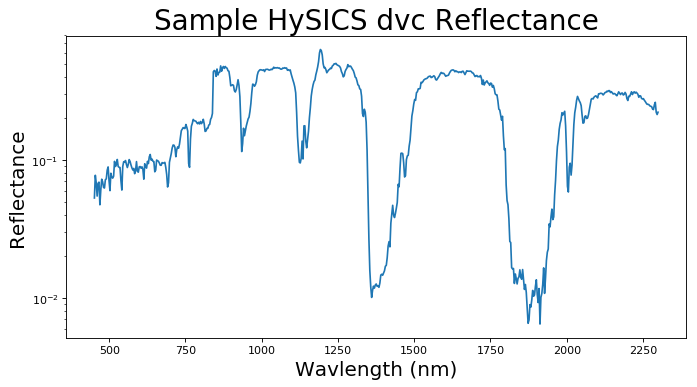

In [20]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.semilogy(refl_hysics_pixel.wavelength,refl_hysics_pixel.values)
plt.xlabel('Wavlength (nm)',fontsize=18)
plt.ylabel('Reflectance',fontsize=18)
tt = 'Sample HySICS dvc Reflectance'
plt.title(tt,fontsize=25)

In [21]:
def find_sigma_k_j(refl_lrt,refl_hysics,idx_1,k,j):
    reflectance_term = (5-k)**2*(refl_lrt.values[j]-refl_hysics.values[j])**2
    ratio_term = (k-1)**2*(refl_lrt.values[j]/refl_lrt.values[idx_1]- refl_hysics.values[j]/refl_hysics.values[idx_1])**2
    sigma_k_j = reflectance_term + ratio_term
    return sigma_k_j

def find_sigma_k(refl_lrt,refl_hysics,retrieval_idx_list,idx_1,i):
    k = i+1
    sigma_k = [find_sigma_k_j(refl_lrt,refl_hysics,idx_1,k,j) for j in retrieval_idx_list[i]] 
    return sigma_k

def calc_disagreement(refl_hysics,refl_lrt,retrieval_idx_list):  
    idx_1 = retrieval_idx_list[0][0]
    
    sigma_all = [find_sigma_k(refl_lrt,refl_hysics,retrieval_idx_list,idx_1,i) for i in np.arange(0,5)] 
    
    sigma = np.sum(sigma_all)
    chi_sq = sigma/(len(retrieval_idx_list[0])*60) 
    diff = np.sqrt(chi_sq)*100
    
    disagreement = xr.DataArray(diff)
    disagreement.attrs['COT'] = refl_lrt.attrs['COT']
    disagreement.attrs['r_eff'] = refl_lrt.attrs['r_eff']
    disagreement.attrs['x'] = refl_hysics.attrs['x']
    disagreement.attrs['y'] = refl_hysics.attrs['y']
    return disagreement;

diff_list = [calc_disagreement(refl_hysics_pixel, r, retrieval_idx_list) for r in refl_lrt_list]
best_diff, idx_diff = min((val, idx) for (idx, val) in enumerate(diff_list))
best_diff

<xarray.DataArray ()>
array(142.302835)
Attributes:
    COT:      1.064246
    r_eff:    5
    x:        0
    y:        0

In [ ]:
rgb_idx_list = find_rgb_idx(datacube_dvc.coords['wavelength'])
red = datacube_dvc.values[:,:,rgb_idx_list[0]]
green = datacube_dvc.values[:,:,rgb_idx_list[1]]
blue = datacube_dvc.values[:,:,rgb_idx_list[2]]

In [ ]:
rgb_unstretched = np.dstack([red,green,blue])

In [ ]:
xx = len(datacube_dvc[:,0,0])
yy = len(datacube_dvc[0,:,0])
x_array = np.arange(0,xx)
y_array = np.arange(0,yy)

In [ ]:
mean_scene = np.zeros((xx,yy), dtype = float)
for y in y_array:
    for x in x_array:
        rgb_pixel = rgb_unstretched[x,y,:]
        mean_scene[x,y] = np.mean(rgb_pixel)

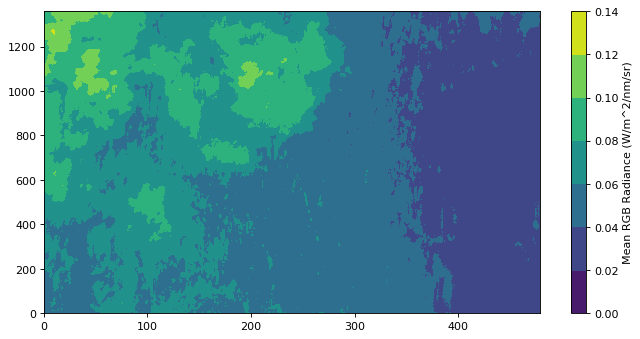

In [ ]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(y_array,x_array,mean_scene)
clb = plt.colorbar()
clb.set_label('Mean RGB Radiance (W/m^2/nm/sr)')

In [ ]:
mask = mean_scene<0.065
masked_mean_scene = np.ma.array(mean_scene, mask=mask)

Text(0.5, 1.0, 'DVC Scene Masked if Mean RGB below 0.065 W/m^2/nm/sr')

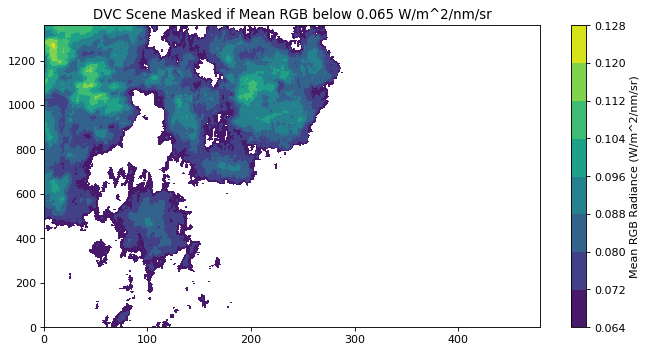

In [ ]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.contourf(y_array,x_array,masked_mean_scene)
clb = plt.colorbar()
clb.set_label('Mean RGB Radiance (W/m^2/nm/sr)')
plt.title('DVC Scene Masked if Mean RGB below 0.065 W/m^2/nm/sr')

In [ ]:
tau_scene = np.zeros((xx,yy), dtype = float)
reff_scene = np.zeros((xx,yy), dtype = float)

def pop_scene(datacube,solar_interp,tau_scene,reff_scene,mask,x,y):
    if mask[x,y] == True: #Mask Ground On
        tau_scene[x,y] = 'NaN'
        reff_scene[x,y] = 'NaN'
            
    elif mask[x,y] == False: #Mask Ground Off    
        refl_hysics_pixel = calc_HySICS_reflectance(datacube,x,y,solar_interp,phase)
        diff_list = [calc_disagreement(refl_hysics_pixel, r, retrieval_idx_list) for r in refl_lrt_list]
        best_diff, idx_diff = min((val, idx) for (idx, val) in enumerate(diff_list))
          
        tau_scene[x,y] = best_diff.COT
        reff_scene[x,y] = best_diff.r_eff
    return tau_scene, reff_scene;

for x in tqdm_notebook(x_array):
    for y in y_array:
        tau_scene, reff_scene  = pop_scene(datacube_dvc,solar_interp,tau_scene,reff_scene,mask,x,y)